In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.speedObservatory import Speed_observatory
import matplotlib.pylab as plt
import healpy as hp
import time
import matplotlib.pylab as plt
%matplotlib inline
from rolling_slair import Target_map_modulo_basis_function

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/utils.py:27: UserWarning: Could not import ts.scheduler. This is required to load the FieldsDatabase. In this case
it will fallback to loading fields from the local "fieldID.lis" file.
  it will fallback to loading fields from the local "fieldID.lis" file.''')


In [2]:
survey_length = 5.#365.25*2.01 # 365.25*10  # days
nside = fs.set_default_nside(nside=32)
years = np.round(survey_length/365.25)
t0 = time.time()

In [3]:
target_map = fs.standard_goals(nside=nside)
norm_factor = fs.calc_norm_factor(target_map)

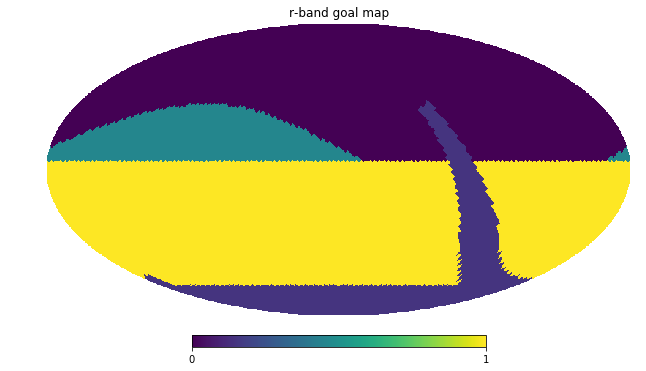

In [4]:
hp.mollview(target_map['r'], title='r-band goal map')
plt.savefig('r_goal.pdf')

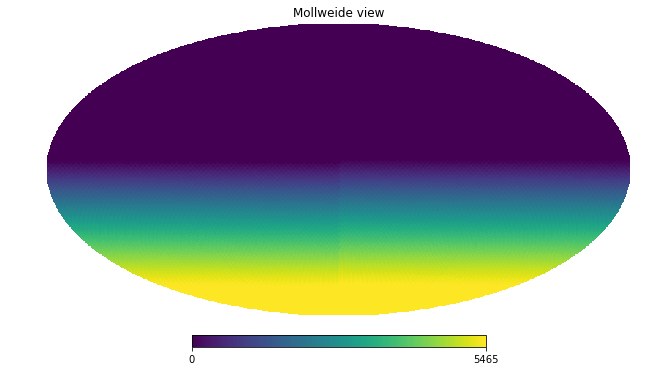

In [5]:
# Let's find the healpix that divides the WFD area in half
wfd = target_map['r'] * 0
wfd[np.where(target_map['r'] == 1)] = 1
wfd_accum = np.cumsum(wfd)
hp.mollview(wfd_accum)
split_indx = np.max(np.where(wfd_accum < wfd_accum.max()/2.))

In [6]:
indx = np.arange(target_map['r'].size)
top_half_wfd = np.where((target_map['r'] == 1) & (indx <= split_indx))
bottom_half_wfd = np.where((target_map['r'] == 1) & (indx > split_indx))
top_half_wfd[0].size, bottom_half_wfd[0].size

(2732, 2733)

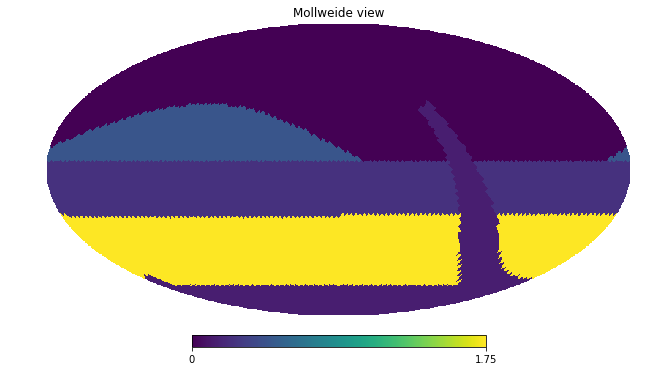

In [7]:
target_map['r'][top_half_wfd] = .25
target_map['r'][bottom_half_wfd] = 1.75
hp.mollview(target_map['r'])

In [8]:

even_year_target = fs.standard_goals(nside=nside)
odd_year_target = fs.standard_goals(nside=nside)

up = 1.75
down = 0.25

for filtername in even_year_target:
    
    even_year_target[filtername][top_half_wfd] *= up
    even_year_target[filtername][bottom_half_wfd] *= down
    
    odd_year_target[filtername][top_half_wfd] *= down
    odd_year_target[filtername][bottom_half_wfd] *= up
    
even_norm = fs.calc_norm_factor(even_year_target)
odd_norm = fs.calc_norm_factor(odd_year_target)

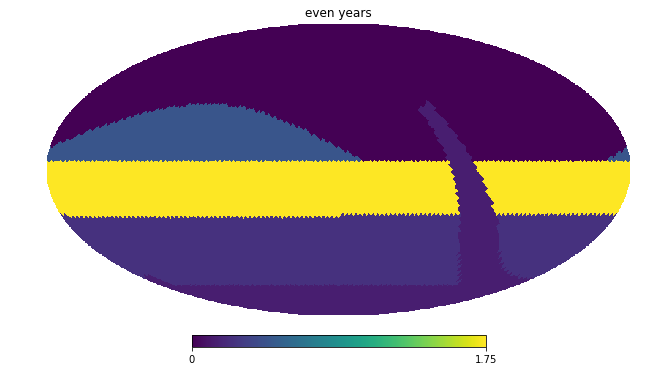

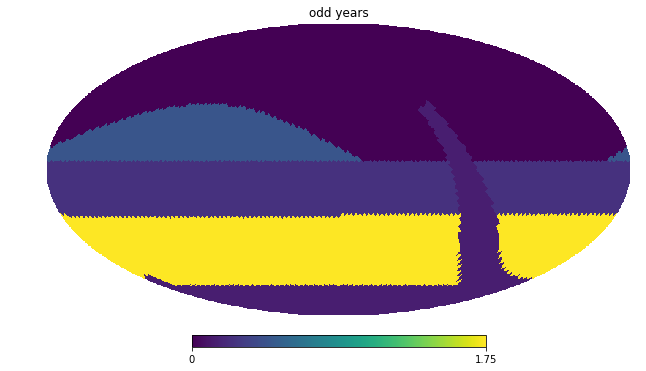

In [9]:
hp.mollview(even_year_target['r'], title='even years')
plt.savefig('even_goal.pdf')
hp.mollview(odd_year_target['r'], title='odd years')
plt.savefig('odd_goal.pdf')

In [10]:
surveys = []
mod_year = 2
offset = 1
# Set up observations to be taken in blocks
filter1s = ['u', 'g', 'r', 'i', 'z', 'y']
filter2s = [None, 'g', 'r', 'i', None, None]
pair_surveys = []
for filtername, filtername2 in zip(filter1s, filter2s):
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    if filtername2 is not None:
        bfs.append(fs.M5_diff_basis_function(filtername=filtername2, nside=nside))
    bfs.append(Target_map_modulo_basis_function(filtername=filtername,
                                            target_map=even_year_target[filtername],
                                                   mod_year=mod_year, offset=0, 
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=even_norm))
    if filtername2 is not None:
        bfs.append(Target_map_modulo_basis_function(filtername=filtername2,
                                                target_map=even_year_target[filtername2],
                                                   mod_year=mod_year, offset=0, 
                                                out_of_bounds_val=hp.UNSEEN, nside=nside,
                                                norm_factor=even_norm))
    
    bfs.append(Target_map_modulo_basis_function(filtername=filtername,
                                            target_map=odd_year_target[filtername],
                                                   mod_year=mod_year, offset=offset, 
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=odd_norm))
    if filtername2 is not None:
        bfs.append(Target_map_modulo_basis_function(filtername=filtername2,
                                                target_map=odd_year_target[filtername2],
                                                   mod_year=mod_year, offset=offset, 
                                                out_of_bounds_val=hp.UNSEEN, nside=nside,
                                                norm_factor=odd_norm))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))
    bfs.append(fs.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
    weights = np.array([3.0, 3.0, .3, .3, 0.3, 0.3, 3., 3., 0.])
    if filtername2 is None:
        # Need to scale weights up so filter balancing still works properly.
        weights = np.array([6.0, 0.6, 0.6, 3., 3., 0.])
    # XXX-
    # This is where we could add a look-ahead basis function to include m5_diff in the future.
    # Actually, having a near-future m5 would also help prevent switching to u or g right at twilight?
    # Maybe just need a "filter future" basis function?
    if filtername2 is None:
        survey_name = 'blob, %s' % filtername
    else:
        survey_name = 'blob, %s%s' % (filtername, filtername2)
    surveys.append(fs.Blob_survey(bfs, weights, filtername=filtername, filter2=filtername2,
                                  survey_note=survey_name))
    

In [11]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
greedy_surveys = []
for filtername in filters:
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(Target_map_modulo_basis_function(filtername=filtername,
                                                mod_year=mod_year, offset=0,
                                            target_map=even_year_target[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=even_norm))
    
    bfs.append(Target_map_modulo_basis_function(filtername=filtername,
                                                mod_year=mod_year, offset=offset,
                                            target_map=even_year_target[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=odd_norm))

    bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50., nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))
    bfs.append(fs.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
    weights = np.array([3.0, 0.3, 0.3, 1., 3., 3., 0.])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    sv = fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername,
                                           dither=True, nside=nside, ignore_obs='DD')
    greedy_surveys.append(sv)


In [12]:
survey_list_o_lists = [surveys, greedy_surveys]

In [13]:
scheduler = fs.Core_scheduler(survey_list_o_lists, nside=nside)
n_visit_limit = None
observatory = Speed_observatory(nside=nside, quickTest=True)
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='rolling_%iyrs.db' % years,
                                                     delete_past=True, n_visit_limit=n_visit_limit)
t1 = time.time()
delta_t = t1-t0
print('ran in %.1f min = %.1f hours' % (delta_t/60., delta_t/3600.))


/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


progress = 100.2%Skipped 0 observations
Completed 3263 observations
ran in 4.7 min = 0.1 hours


In [14]:
surveys[1].basis_functions

In [15]:
for bf in surveys[1].basis_functions[2:6]:
    print(bf(), bf.offset, bf.mod_year)

[ -1.63750000e+30  -1.63750000e+30  -1.63750000e+30 ...,   5.06690627e-02
   5.06690627e-02   5.06690627e-02] 0 2
[ -1.63750000e+30  -1.63750000e+30  -1.63750000e+30 ...,   5.06690627e-02
   5.06690627e-02   5.06690627e-02] 0 2
0 1 2
0 1 2


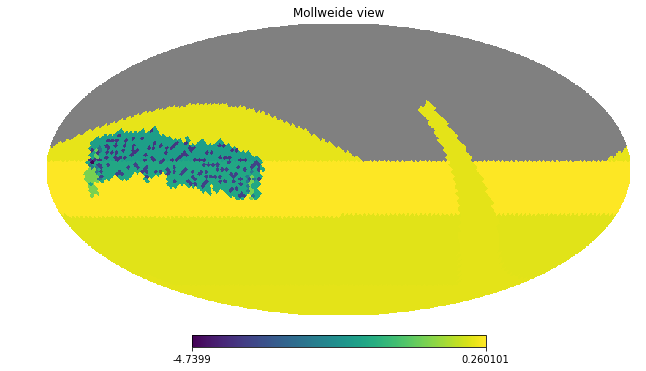

In [16]:
hp.mollview(surveys[1].basis_functions[2]())

In [17]:
surveys[1].basis_functions[3]

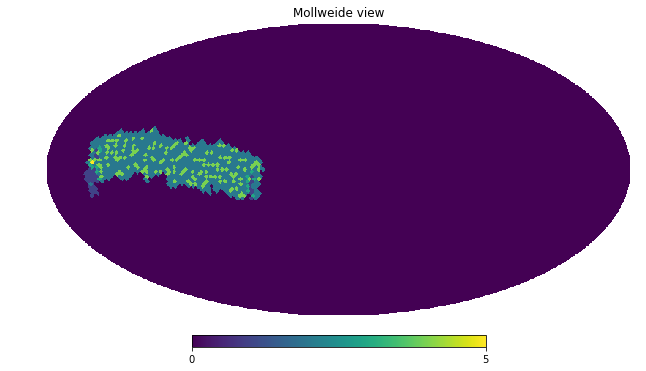

In [18]:
hp.mollview(surveys[1].basis_functions[3].survey_features['N_obs'].feature)

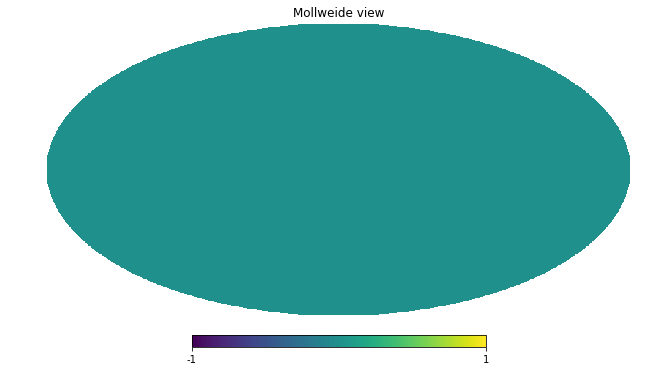

In [19]:
hp.mollview(surveys[1].basis_functions[4].survey_features['N_obs'].feature)

In [20]:
surveys[1].basis_functions[4]()

0

In [21]:
(surveys[1].basis_functions[4].condition_features['Current_mjd'].feature - surveys[1].basis_functions[4].mjd0)/365.25

0.013717012685162004

In [22]:
np.unique(observations['note'])

array(['', 'blob, gg, a', 'blob, gg, b', 'blob, ii, a', 'blob, ii, b',
       'blob, rr, a', 'blob, rr, b', 'blob, y', 'blob, z'],
      dtype='<U40')